In [199]:
import jax.numpy as np
import numpy as NP
from jax.nn import one_hot,sigmoid
from functools import partial
from jax import random,vmap,value_and_grad
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import optax
import pickle as pkl

from rnn_init import *
from rnn_run import *
from utils import *
from plot_tools import *

In [200]:
def load_from_text():
    """
    Loads text file where the first line is current values
    Rest of the lines are voltage traces.
    """
    import numpy as np
    with open('camp_proj.txt','r') as f:
        lines = f.readlines()
    values = []
    for line in lines:
        val=line.split(',')[:-2]
        val = NP.array(val).astype(float)
        values.append(val)
    stim = values[0]
    return stim,np.stack(values[1:])

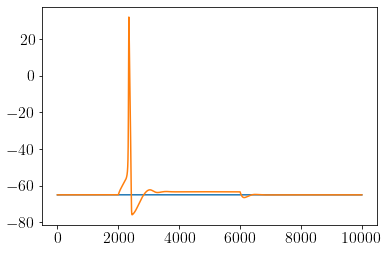

In [201]:
stim,values = load_from_text()
l=plt.plot(values[:2,:].T)

#def get_inptraces_from_stim(stim):
    

In [202]:
seed = 1
key = random.PRNGKey(seed)
#key,skey = random.split(key)
key,skeys = genkeys_array(key,1)
#params = init_vanilla_rnn_params(key,2,2,1)
#params = init_gru_rnn_params(skey,1,2,1)

In [203]:
#params['wO'] = np.array([[1.0,0.0]])

In [204]:
rnn_run,init_rnn,param_keys = get_rnn_and_init_keys_funcs(run_type='run',arch='CTVanilla',trial_dims=1,param_dims=1)
params = init_rnn(skeys,1,2,1)

None


In [205]:
rnn,_,_ = get_rnn_and_init_keys_funcs(run_type='rnn',arch='CTVanilla',trial_dims=2,param_dims=1)
grid_s = 11
I = np.zeros((grid_s,grid_s,1,1))
h = np.zeros((grid_s,grid_s,2,1))
out = rnn(params,h,I)
out.shape

None


(1, 11, 11, 2, 2)

In [206]:
rnn,_,_ = get_rnn_and_init_keys_funcs(run_type='rnn',arch='CTVanilla',trial_dims=0,param_dims=1)
rnn(params,np.arange(10))

None


ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification ({'wI': 0, 'wR': 0, 'wO': 0, 'bR': 0}, None, None) for value tree PyTreeDef(({'bR': *, 'wI': *, 'wO': *, 'wR': *}, *)).

In [207]:
h = np.linspace(-1,1,grid_s)
H = np.stack(np.meshgrid(h,h),-1)[...,None]
rnn(params,H,I).shape

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (11, 11, 1, 1), (11, 11, 2, 1).

In [188]:
X.shape

(11, 11, 2, 1)

In [138]:
#plt.plot(inp[:,:,0].T)
#plt.plot(out[:,:,0].T)

In [208]:
#inp = np.array(data['stim'])[:,:,None]
#out = rnn_run(params,inp)

@jit
def loss(y,targ,mask):
    return np.mean(mask*(y-targ)**2)

#vloss = vmap(loss,(0,None,None),0)

@jit
def L(params,inp,targ,mask):
    out = rnn_run(params,inp)
    print(out.shape,targ[None].shape,mask[None].shape)
    return loss(out,targ[None],mask[None])



vLgrad = jit(value_and_grad(L))

In [209]:
#vLgrad(params,inp,targ,mask)

In [210]:
def train(Params,
          data,
          key,
          num_steps = 200,
          sample_data = None,
          learning_rate = 5e-2,
          trial_bs = 200,
          test_trial_bs = 20):
    
    params = Params.copy()
    
    
    optimizer = optax.sgd(learning_rate)
    opt_state = optimizer.init(params)
    

    def step_full(step, opt_state, params, data):
        inp,targ,mask = data
        #print(inp.shape,targ.shape,mask.shape)
        value, grads = vLgrad(params,inp,targ,mask)
        l = value
        #l,X = lX
        updates,opt_state = optimizer.update(grads,opt_state,params=params)
        params = optax.apply_updates(params,updates)
        #opt_state = opt_update(step, grads, opt_state)
        return l, params, opt_state

    def append_noise(skey,data,N,scale):
        inp,task,mask = data
        noise = random.normal(skey,(inp.shape[0],inp.shape[1],N)) * scale
        inp = np.concatenate([inp,noise],-1) 
        return inp,task,mask

    key,skeys = genkeys(key,num_steps*2+5)

    loss_hist = []

    X_hist = []

    #N = params['wR'].shape[-1]


    #task = vmap(task,0,0)

    #key,skeys = genkeys_array(key,test_trial_bs)
    #test_data = task(skeys)

    for i in tqdm(np.arange(num_steps)):
        key,skeys = genkeys_array(key,trial_bs)
        #data = task(skeys)
        key,skey = random.split(key)
        #data = append_noise(skey,data,N,0.005)
        #noise = random.normal(skey,shape = data[0].shape) * 1e-3
        #data = (data[0]+noise,data[1],data[2])
        value,  params, opt_state = step_full(i,opt_state,params,data)


        #inp,targ,mask = sample_data
        #params['wR'] = get_params(opt_state)
        #state_t,_ = run(params,inp)

        #if i%10==0:
        #    X_hist.append(state_t)

        loss_hist.append(value)  #test_err)
    #tparams = get_params(opt_state)
    tparams = params
    return tparams,np.stack(loss_hist)

In [211]:
with open('data/HHdata.pkl','rb') as f:
    data = pkl.load(f)

inp = np.array(data['stim'])[:,::150,None]/50
targ = np.array(data['Vm'])[:,::150,None]/100
#inp,targ = targ,inp
#targ = np.ones(targ.shape)
#inp = np.zeros(inp.shape)
mask = np.ones(targ.shape)
rdata = (inp,targ,mask)
tparams,loss_hist = train(params,rdata,key,learning_rate=4e-2,num_steps = 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

(1, 3, 34, 1) (1, 3, 34, 1) (1, 3, 34, 1)


In [212]:
inp.shape,targ.shape,mask.shape

((3, 34, 1), (3, 34, 1), (3, 34, 1))

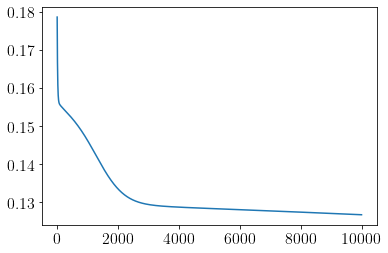

In [142]:
plt.plot(loss_hist)

In [43]:
out_init = rnn_run(params,inp)
out = rnn_run(tparams,inp)

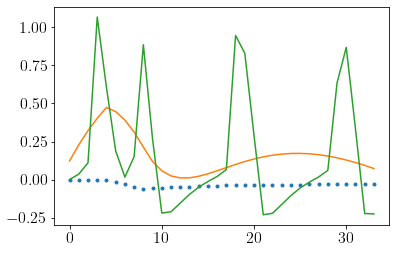

In [44]:
plt.plot(out_init[0,0,:,0].T,'.')
plt.plot(out[0,0,:,0].T)
plt.plot(targ[0,:,0].T)

#plt.plot(inp[0,:,0])
#inp = data['stim']
#targ = data['Vm']
#mask = np.ones(targ.shape)
#rdata = (inp,targ,mask)

In [637]:
#plt.plot(inp[0,:,0])
#plt.plot(targ[0,:,0])

In [638]:
def ddtask(key,inp_t_range1=(2,10),inp_t_range2=(7,10),amp_range=(1,2),cue_t_range=(3,7),targ_t_in = 5,targ_dur=6,T=30):
    """
    Single input pulse, amplitude categorisation task.
    """
    key,skeys = genkeys_array(key,10)
    t1 = random.choice(skeys[0],inp_t_range1[1]-inp_t_range1[0]) + inp_t_range1[0]
    amp1 = random.uniform(skeys[1]) * (amp_range[1]-amp_range[0]) + amp_range[0]
    t2_ = random.choice(skeys[2],inp_t_range2[1]-inp_t_range2[0]) + inp_t_range2[0]
    amp2 = random.uniform(skeys[3]) * (amp_range[1]-amp_range[0]) + amp_range[0]
    t2 = t1 + t2_
    inp1 = one_hot(t1,T) * amp1
    inp2 = one_hot(t2,T) * amp2
    cue_t = random.choice(skeys[0],cue_t_range[1]-cue_t_range[0]) + cue_t_range[0] + t2
    targ = np.ones(T) * (amp1>amp2) * 2 - 1
    cue = one_hot(cue_t,T)
    targ_t = targ_t_in + cue_t
    #targ_ts = np.arange(targ_t,targ_t+targ_dur)
    counter = np.arange(T)
    mask = (counter>=targ_t) * (counter<(targ_t+targ_dur)) * (np.tanh(10*(amp1-amp2))**2)
    mask = mask.astype(inp1.dtype)
    #mask = one_hot(targ_ts,T).sum(0)
    inp = np.stack([inp1,inp2,cue],1)
    return inp,targ[...,None],mask[...,None]
tparams,loss_hist = train(params,ddtask,key,learning_rate=1e-3)

  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: 'function' object is not subscriptable

In [710]:
def loss_sep(y,targ,mask):
    return np.mean(mask*(y-targ)**2,axis=(1,2,3))

def Lsep(params,inp,targ,mask):
    out = rnn_run(params,inp)
    print(out.shape,mask[None].shape)
    return loss_sep(out,targ[None],mask[None])
Lsep(tparams,inp,targ,mask)

(10, 1, 50, 1) (1, 1, 50, 1)


DeviceArray([0.14629228, 0.14836165, 0.14816242, 0.14682671, 0.14719716,
             0.13491048, 0.14682171, 0.14797105, 0.12774108, 0.14863178],            dtype=float32)

In [342]:
with open('data/HHdata.pkl','rb') as f:
    data = pkl.load(f)

In [96]:
#NP.genfromtxt('camp_proj.txt','delimiter=',')
#plt.plot(values[0])

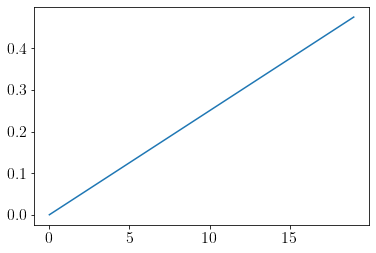

In [109]:
#plt.plot(values[0])
#plt.plot(values[0])